In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#!unrar x /content/drive/MyDrive/DeepPCB.rar

In [3]:
def iou_map(preds, truths, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    #print(pred.shape, truths.shape)
    ious = [compute_iou(pred, truth) for truth, pred in zip(truths, preds)]
    
    print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [4]:
def compute_iou(y_pred, labels):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions
    
    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """
    if y_pred.dtype != 'int64':
        y_pred = y_pred.detach().numpy()
        y_pred = np.argmax(y_pred,axis=1)
        labels = labels.detach().numpy()
    #print(y_pred.dtype, labels.dtype)
    #print(y_pred.shape, labels.shape)
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union

    return iou[0:, 0:]  # exclude background

In [5]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # # You can comment out this line if you are passing tensors of equal shape
    # # But if you are passing output from UNet or something it will most probably
    # # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-6
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    #print(intersection, union)
    return iou
    #-------------------------------------------------------------------------------- # 

In [6]:
def pred_check(model, data):
    model.eval()   # testing mode
    for X_batch, Y_batch in data:
        Y_hat = model(X_batch.cuda()).detach().to('cpu')
        break
    Y_hat = Y_hat.numpy()
    Y_hat = np.argmax(Y_hat,axis=1) 
    plt.figure(figsize=(18, 6))
    for k in range(5):
        plt.subplot(2, 5, k+1)
        plt.imshow(np.rollaxis(Y_batch[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')
        
        plt.subplot(2, 5, k+6)
        plt.imshow(Y_hat[k], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [7]:
def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

In [8]:
def dice_loss(y_real, y_pred):
    num = 2 * torch.sum(y_real*y_pred)
    den =  torch.sum(y_real + y_pred)
    const = 1/(128*128)
    res = 1 - const*num/den
    return res

In [9]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    l_bce = - (y_real * y_pred) + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    sum_val = torch.sum(l_bce)
    size_val = len(l_bce)
    return sum_val/size_val

In [10]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    #sigmoid_y_pred = torch.sigmoid(y_pred)
    your_loss = -torch.sum((1-torch.pow(y_pred, gamma)) * y_real * torch.log(y_pred) + (1-y_real) * torch.log(1-y_pred)) # hint: torch.clamp
    return your_loss


In [11]:
def score_model(model, metric, data):
    model.to('cpu')
    model.eval()  # testing mode
    scores = 0
    scor = []
    for X_batch, Y_label in data:
        #X_batch = X_batch.cuda()
        Y_pred = model(X_batch)
        #print(Y_pred.shape)
        scores += metric(Y_pred.to('cpu'), Y_label.to('cpu')).sum().item()
        scor.append(metric(Y_pred.to('cpu'), Y_label.to('cpu')).sum().item())
    model.to('cuda')
    return scores/100

In [12]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_histry = []
    iou_histry = []
    IoU = 0 
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        IoU = score_model(model, compute_iou, data_val)
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            #print(X_batch.shape, '\n', Y_batch.shape) #torch.permute(Y_batch, (0,3,1,2))
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            #print(Y_pred.shape, Y_batch.shape)
            loss = loss_fn()(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.cuda()).detach().to('cpu') # detach and put into cpu
        #print(Y_hat.shape, '\n', Y_batch.shape)
        # Visualize tools
        #clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            #print(Y_hat.shape, k, '\n')
            pred = Y_hat.numpy()
            out2 = np.argmax(pred,axis=1)   
            plt.imshow(out2[k], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f IoU: %f' % (epoch+1, epochs, avg_loss, IoU))
        plt.show()
        loss_histry.append(avg_loss)
        iou_histry.append(IoU)
    return loss_histry, iou_histry

In [13]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [14]:
PATH = 'DeepPCB/PCBData'

normal = []
defect = []
defectlog = []
path_2 = [os.path.join(PATH,dir) for dir in os.listdir(PATH) if '.' not in dir]
for p in tqdm(path_2,total=len(path_2)):
    path_3 = os.path.join(p,sorted(os.listdir(p))[0])
    normal +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'temp' in dir]
    defect +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'test' in dir]
    path_4 = os.path.join(p,sorted(os.listdir(p))[1])
    defectlog +=[os.path.join(path_4,dir)for dir in os.listdir(path_4)]
normal.sort()
defect.sort()
defectlog.sort()

  0%|          | 0/11 [00:00<?, ?it/s]

In [15]:
img0 = []
img1 = []
for img_path in tqdm(normal,total=len(normal)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img0.append(img)
for img_path in tqdm(defect,total=len(defect)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img1.append(img)
img0 = np.array(img0)
img1 = np.array(img1)
# with open(path+'img0.pkl', 'wb') as f:
#     pickle.dump(img0, f, pickle.HIGHEST_PROTOCOL)
# with open(path+'img1.pkl', 'wb') as f:
#     pickle.dump(img1, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [16]:
box = []
i=0
for log in tqdm(defectlog,total=len(defectlog)):
    temp = pd.read_csv(log,sep=' ' ,names=['x1', 'y1', 'x2', 'y2', 'defect'], header=None).values.tolist()
    box.append(temp)
    i+=1
boxarr = []
for i in tqdm(range(len(box))):
    narr = np.zeros((640,640,1))
    for j in range(len(box[i])):
        x1,y1,x2,y2,d = box[i][j]
        narr = cv2.rectangle(narr,(x1,y1),(x2,y2),d,-1)
    narr = cv2.resize(narr,(128,128))
    boxarr.append(narr)
boxarr = np.array(boxarr)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [17]:
# masksarr = []
# masks = np.zeros((128, 128, 7))
# for mask_box in boxarr:
#     for dim in range(7):
#         masks[:,:,dim] = mask_box==dim
#     masksarr.append(masks)
# masksarr = np.array(masksarr)

In [18]:
# plt.imshow(np.reshape(boxarr[0],(128,128)),cmap='gnuplot')
# plt.show()

In [19]:
# plt.imshow(np.reshape(img1[0],(128,128)),cmap='gnuplot')
# plt.show()

In [20]:
rand =  np.random.choice(len(img1), len(img1), False)
tr_ind, val_ind = rand[:1200], rand[1350:1450]

In [21]:
img1 = np.array(img1, np.float32)
boxarr = np.array(boxarr, np.int64)

In [22]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(img1[tr_ind, np.newaxis], boxarr[tr_ind])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(img1[val_ind, np.newaxis], boxarr[val_ind, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

In [23]:
for tr, tar in data_tr:
    print(tar.dtype)
    break

torch.int64


In [24]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential( 
                            nn.Conv2d(in_channels = 1, out_channels=64, kernel_size=5, padding=2),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=2, stride = 2)
                            )
        # 256 -> 128
        self.enc_conv1 = nn.Sequential( 
                            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=2, stride = 2) 
                            )
        # 128 -> 64
        self.enc_conv2 = nn.Sequential( 
                            nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=2, stride = 2) 
                            )
        # 64 -> 32
        self.enc_conv3 = nn.Sequential( 
                            nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=2, stride = 2) 
                            )
        # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential( 
                            nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size=3, padding=1),
                            nn.BatchNorm2d(1024),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=1),
                            nn.BatchNorm2d(1024),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU()
                            )

        # decoder (upsampling)
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        #self.upsample = nn.ConvTranspose2d()
        self.dec_conv0 = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2), 
                            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU()
                            )
        # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
                            nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU()
                            )
        # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
                            nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU()
                            )
        # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
                            nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 64, out_channels=32, kernel_size=3, padding=1),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 32, out_channels=7, kernel_size=1),
                            )

    def forward(self, x):
        # encoder
        #input_shape = x.shape
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(input = b)
        d0_cat = torch.cat([e2, d0], dim=1)
        d1 = self.dec_conv1(input = d0_cat)
        d1_cat = torch.cat([e1, d1], dim=1)
        d2 = self.dec_conv2(input = d1_cat)
        d2_cat = torch.cat([e0, d2], dim=1)
        d3 = self.dec_conv3(input = d2_cat)

        return d3


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
unet2_PCB = UNet2().to('cuda')

In [27]:
loss_history = []
iou_history = []

In [37]:
epoch = 10
optimer = torch.optim.Adam(unet2_PCB.parameters(), lr=0.000001)

In [38]:
torch.cuda.empty_cache()

* Epoch 1/10
loss: 0.012957


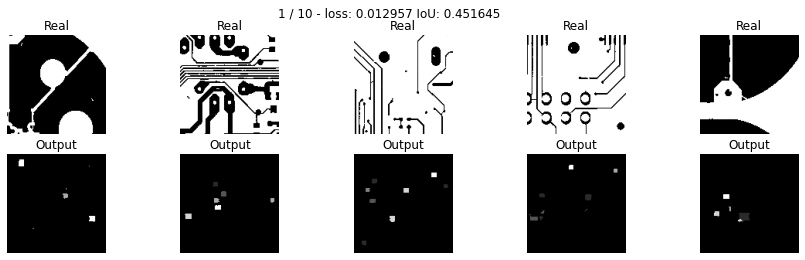

* Epoch 2/10
loss: 0.012875


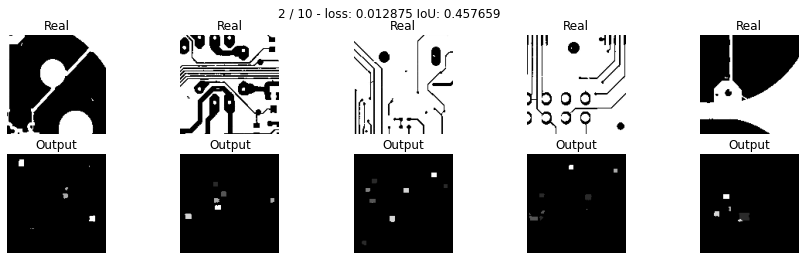

* Epoch 3/10
loss: 0.012961


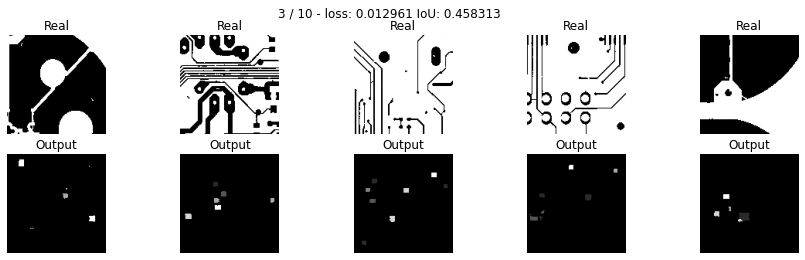

* Epoch 4/10
loss: 0.012821


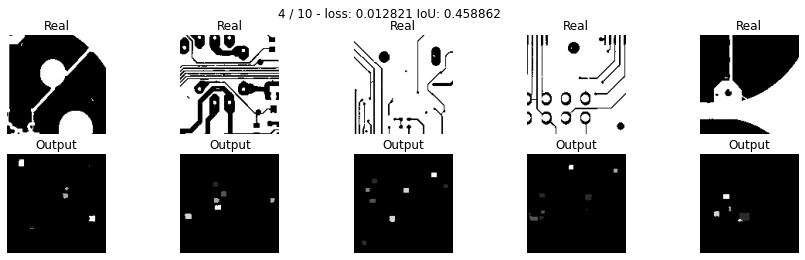

* Epoch 5/10
loss: 0.012818


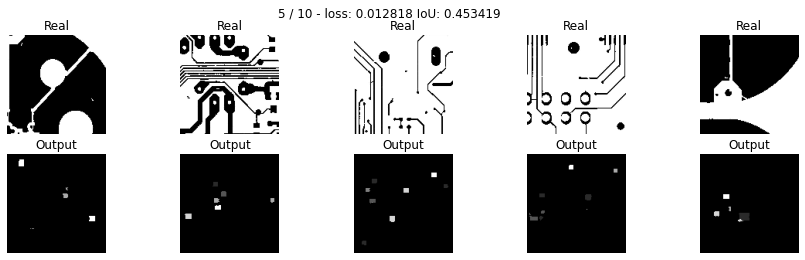

* Epoch 6/10
loss: 0.012844


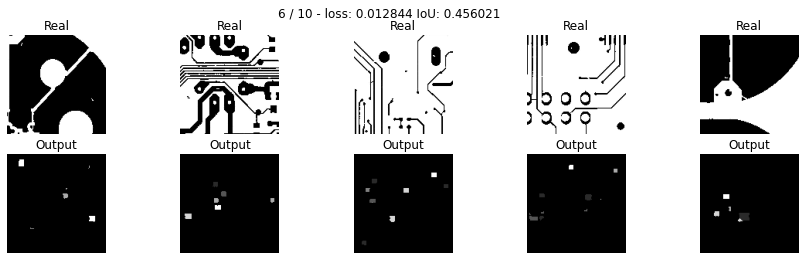

* Epoch 7/10
loss: 0.012818


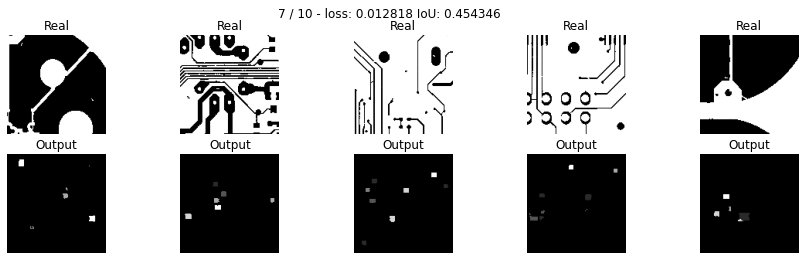

* Epoch 8/10
loss: 0.012924


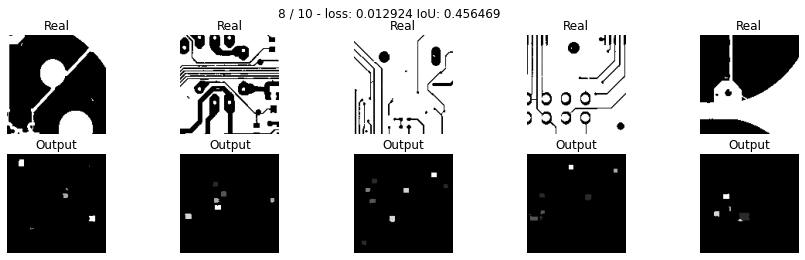

* Epoch 9/10
loss: 0.012765


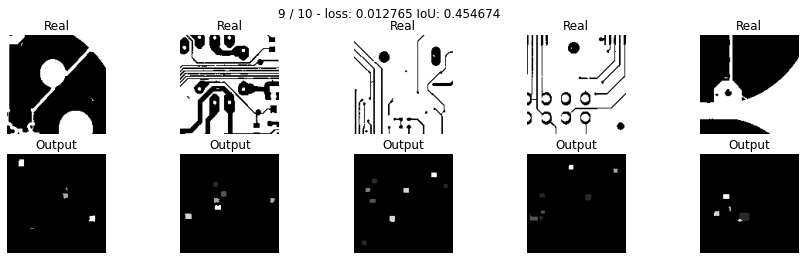

* Epoch 10/10
loss: 0.012793


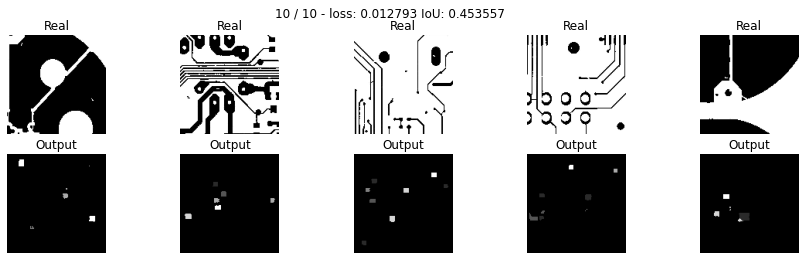

In [39]:
los, iou = train(unet2_PCB, optimer, nn.CrossEntropyLoss, epoch, data_tr, data_val)
for eph in range(epoch):
    loss_history.append(los[eph].item())
    iou_history.append(iou[eph])

<function matplotlib.pyplot.show(close=None, block=None)>

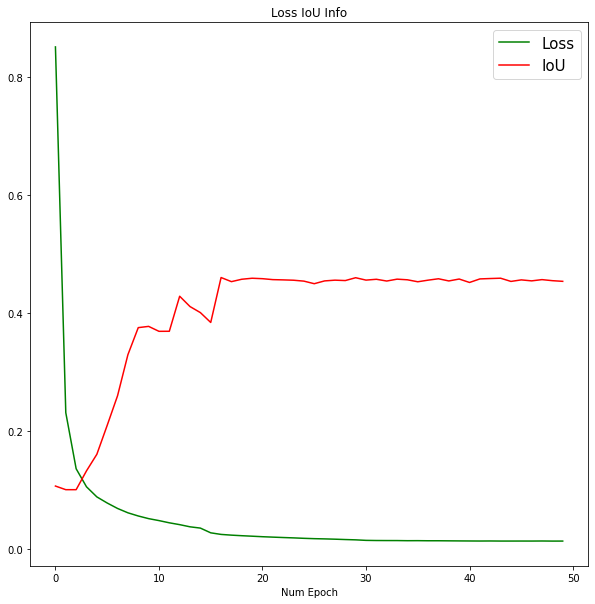

In [40]:
plt.figure(figsize=(10, 10))
plt.plot(range(len(loss_history)),loss_history, color='g', label='Loss')
plt.plot(range(len(iou_history)),iou_history, color='r',  label='IoU')
plt.title("Loss IoU Info")      
plt.xlabel('Num Epoch')
plt.legend(fontsize=15, loc=0)
plt.show 

In [ ]:
unet2_PCB.eval()
torch.save(unet2_PCB, "C:\\Users\\d5k18\\Desktop\\ML\\PCDDefect\\save_model\\Unet2_los_0012_Iou_43.pth")

In [ ]:
score_model(unet2_PCB, iou_pytorch, data_val)

In [101]:
img_t = torch.tensor(img1)
img_t[0][np.newaxis].detach 

<function Tensor.detach>

In [106]:
unet2_PCB.eval()
unet2_PCB.to('cpu')
img_index = 325
pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
pred = pred.detach().numpy()
out2 = np.argmax(pred,axis=1)

In [107]:
iou_map(out2, boxarr[img_index][np.newaxis], verbose=1)

(7, 5)
Thresh	TP	FP	FN	Prec.
0.500	3	2	4	0.333
0.550	2	3	5	0.200
0.600	2	3	5	0.200
0.650	2	3	5	0.200
0.700	2	3	5	0.200
0.750	1	4	6	0.091
0.800	1	4	6	0.091
0.850	1	4	6	0.091
0.900	1	4	6	0.091
0.950	1	4	6	0.091
AP	-	-	-	0.159


0.15878787878787876

In [ ]:
img_t = torch.tensor(img1)
img_t[0][np.newaxis].detach 

In [ ]:
unet2_PCB.eval()
unet2_PCB.to('cpu')
img_index = 227
pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
pred = pred.detach().numpy()
out2 = np.argmax(pred,axis=1)

In [ ]:
precision_at(0, compute_iou(out2[0], boxarr[img_index]))

In [ ]:
iou_map(out2, boxarr[img_index][np.newaxis], verbose=1)

In [ ]:
masks = [boxarr[img_index], out2[0]]
for id, mask in enumerate(masks):
    plt.subplot(1, 2, id+1)
    plt.imshow(mask,cmap='gnuplot')
plt.show()

In [42]:
img_t = torch.tensor(img1)
img_t[0][np.newaxis].detach 

<function Tensor.detach>

In [99]:
img_index = 325

(128, 128)


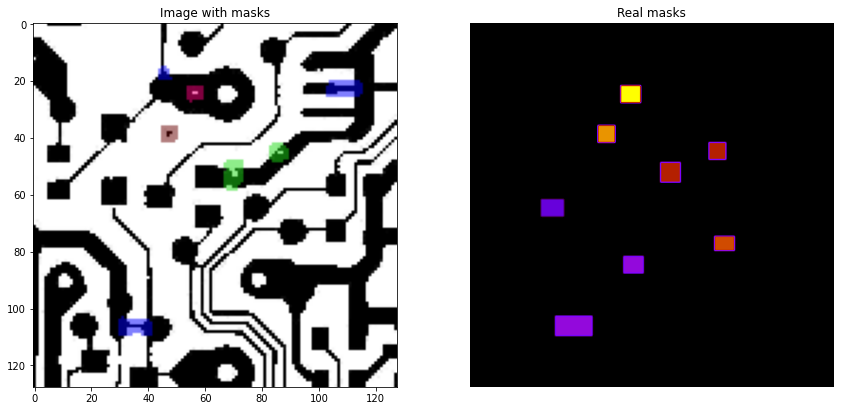

In [100]:
unet2_PCB.to('cpu')
pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
pred = np.argmax(pred.detach().numpy(),axis=1)[0]

img_arr_resized = cv2.resize(img1[img_index],(128,128))
img_arr_resized = cv2.cvtColor(img_arr_resized,cv2.COLOR_GRAY2RGB)

img_arr_resized = img_arr_resized.astype('uint8')
new_pred = np.zeros((128,128,3),dtype=np.uint8)
print(pred.shape)
new_pred[pred==0] = img_arr_resized[pred==0]
new_pred[pred==1] = [255,228,0] #open
new_pred[pred==2] = [1,0,255] #short
new_pred[pred==3] = [29,219,22] #mousebite
new_pred[pred==4] = [255,0,0] #spur
new_pred[pred==5] = [103,0,0] #copper
new_pred[pred==6] = [255,0,127] #pin-hole

blend_img1=Image.fromarray(img_arr_resized)
blend_img2=Image.fromarray(new_pred)
blend_img=Image.blend(blend_img1,blend_img2,0.5)
plt.figure(figsize=(30,30))
legend1 = mpatches.Patch(color='#FFE400', label='open')
legend2 = mpatches.Patch(color='#0100FF', label='short')
legend3 = mpatches.Patch(color='#1DDB16', label='mousebite')
legend4 = mpatches.Patch(color='#FF0000', label='spur')
legend5 = mpatches.Patch(color='#670000', label='copper')
legend6 = mpatches.Patch(color='#FF007F', label='pinhole')
plt.legend(loc='lower left', handles=[legend1,legend2,legend3,legend4,legend5,legend6],mode = "expand", ncol = 3,fontsize=10)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 1)
plt.imshow(np.array(blend_img))
plt.title('Image with masks')
plt.subplot(1, 4, 2)
plt.imshow(boxarr[img_index],cmap='gnuplot')
plt.title('Real masks')
plt.axis('off')
plt.show()

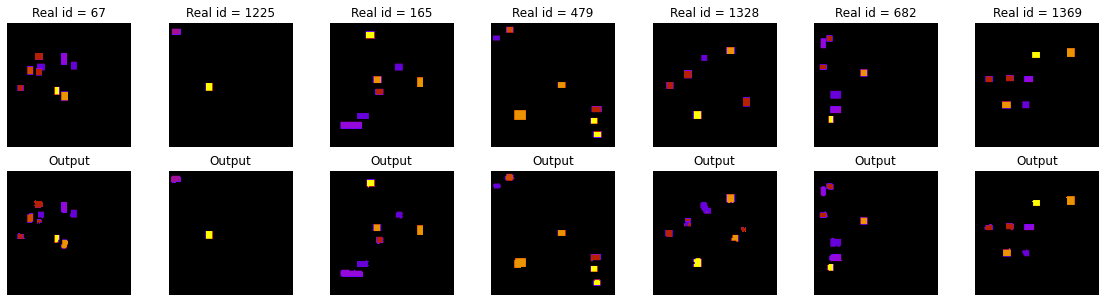

In [98]:
unet2_PCB.to('cpu')
lst = np.random.randint(0, 1500, 7)
prediction = []
masks = []
for ind in lst:
    img_index = ind
    unet2_PCB.eval()
    unet2_PCB.to('cpu')
    pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
    pred = pred.detach().numpy()
    out2 = np.argmax(pred,axis=1)
    prediction.append(out2)
    masks.append(boxarr[img_index])
plt.figure(figsize=(40,5))
for id, mask in enumerate(masks):
    plt.subplot(2, 14, id+1)
    plt.imshow(mask,cmap='gnuplot')
    plt.title('Real id = %d' % (lst[id]))
    plt.axis('off')
    
    plt.subplot(2, 14, id+15)
    plt.imshow(prediction[id][0],cmap='gnuplot')
    plt.title('Output')
    plt.axis('off')
plt.show()

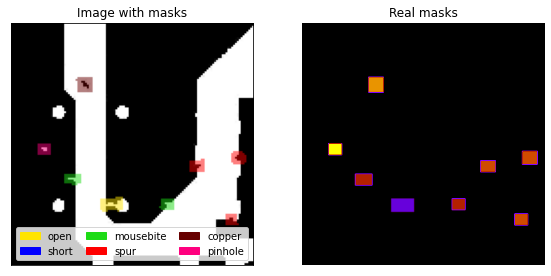

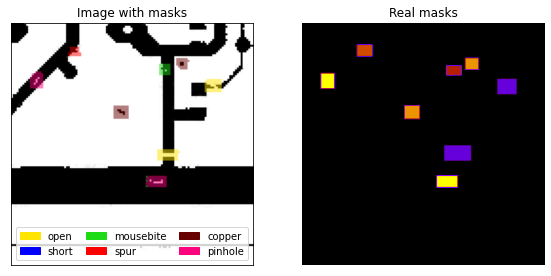

In [67]:
lst = np.random.randint(0, 1500, 2)
prediction = []
masks = []
for ind in lst:
    img_index = ind
    unet2_PCB.eval()
    unet2_PCB.to('cpu')
    pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
    pred = pred.detach().numpy()
    out2 = np.argmax(pred,axis=1)
    prediction.append(out2)
    masks.append(boxarr[img_index])

for id, pred in enumerate(prediction):
    plt.figure(figsize=(20,20))
    img_arr_resized = cv2.resize(img1[lst[id]],(128,128))
    img_arr_resized = cv2.cvtColor(img_arr_resized,cv2.COLOR_GRAY2RGB)
    img_arr_resized = img_arr_resized.astype('uint8')
    new_pred = np.zeros((128,128,3),dtype=np.uint8)
    pred = pred[0]
    new_pred[pred==0] = img_arr_resized[pred==0]
    new_pred[pred==1] = [255,228,0] #open
    new_pred[pred==2] = [1,0,255] #short
    new_pred[pred==3] = [29,219,22] #mousebite
    new_pred[pred==4] = [255,0,0] #spur
    new_pred[pred==5] = [103,0,0] #copper
    new_pred[pred==6] = [255,0,127] #pin-hole
    blend_img1=Image.fromarray(img_arr_resized)
    blend_img2=Image.fromarray(new_pred)
    blend_img=Image.blend(blend_img1,blend_img2,0.5)
    legend1 = mpatches.Patch(color='#FFE400', label='open')
    legend2 = mpatches.Patch(color='#0100FF', label='short')
    legend3 = mpatches.Patch(color='#1DDB16', label='mousebite')
    legend4 = mpatches.Patch(color='#FF0000', label='spur')
    legend5 = mpatches.Patch(color='#670000', label='copper')
    legend6 = mpatches.Patch(color='#FF007F', label='pinhole')
    plt.subplot(1, 4, id+1)
    plt.legend(loc='lower left', handles=[legend1,legend2,legend3,legend4,legend5,legend6],mode = "expand", ncol = 3,fontsize=10)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(np.array(blend_img))
    plt.title('Image with masks')
    plt.subplot(1, 4, id+2)
    plt.imshow(masks[id],cmap='gnuplot')
    plt.title('Real masks')
    plt.axis('off')
    
    plt.show()


================================================================================================================================== 

In [ ]:
pred = unet2_PCB(torch.reshape(img_t[img_index][np.newaxis], (1,1,128,128)))
pred = np.argmax(pred.detach().numpy(),axis=1)[0]

In [ ]:
img_arr_resized = cv2.resize(img1[img_index],(128,128))
img_arr_resized = cv2.cvtColor(img_arr_resized,cv2.COLOR_GRAY2RGB)

img_arr_resized = img_arr_resized.astype('uint8')
new_pred = np.zeros((128,128,3),dtype=np.uint8)

new_pred[pred==0] = img_arr_resized[pred==0]
new_pred[pred==1] = [255,228,0] #open
new_pred[pred==2] = [1,0,255] #short
new_pred[pred==3] = [29,219,22] #mousebite
new_pred[pred==4] = [255,0,0] #spur
new_pred[pred==5] = [103,0,0] #copper
new_pred[pred==6] = [255,0,127] #pin-hole

In [ ]:
blend_img1=Image.fromarray(img_arr_resized)
blend_img2=Image.fromarray(new_pred)
blend_img=Image.blend(blend_img1,blend_img2,0.5)

In [ ]:
legend1 = mpatches.Patch(color='#FFE400', label='open')
legend2 = mpatches.Patch(color='#0100FF', label='short')
legend3 = mpatches.Patch(color='#1DDB16', label='mousebite')
legend4 = mpatches.Patch(color='#FF0000', label='spur')
legend5 = mpatches.Patch(color='#670000', label='copper')
legend6 = mpatches.Patch(color='#FF007F', label='pinhole')
plt.legend(loc='lower left', handles=[legend1,legend2,legend3,legend4,legend5,legend6],mode = "expand", ncol = 3,fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(np.array(blend_img))
plt.show()